# Local Covid-19 Metrics

## Gather Datasets

In [3]:

# init
import pandas as pd
import requests
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from pandas import DataFrame

# set parameters
days_back = 365

# get content from web APIs
us = requests.get('https://covidtracking.com/api/v1/us/daily.json')
us = us.text
us = pd.read_json(us)

pa = requests.get('https://covidtracking.com/api/v1/states/pa/daily.json')
pa = pa.text
pa = pd.read_json(pa)

nj = requests.get('https://covidtracking.com/api/v1/states/nj/daily.json')
nj = nj.text
nj = pd.read_json(nj)

# we can only get the past 7 days for bucks county with this API
# bucks_data = requests.get('https://localcoviddata.com/covid19/v1/cases/newYorkTimes?zipCode=19067&daysInPast=7')
# bucks_data = bucks_data.text
# bucks_data = pd.read_json(bucks_data)
# bucks_data = bucks_data.counties[0].get("historicData")
# bucks_data = DataFrame (bucks_data,columns=['date','deathCt','positiveCt'])
# bucks_data['date'] = pd.to_datetime(pd.Series(bucks_data['date']), format="%Y-%m-%d")

# derive positive and death for bucks
# diff = bucks_data[['deathCt','positiveCt']].diff(periods=-1)
# bucks = bucks_data.join(diff, lsuffix='_caller', rsuffix='_other')
# bucks = bucks.rename(columns={'deathCt_caller':'death_total'
#                       ,'positiveCt_caller':'positive_total'
#                       ,'deathCt_other':'death'
#                       ,'positiveCt_other':'positive'})

# massage datasets

# make function for the covid tracking api since they are all the same
def clean_covidtracking_api_data(df):
    
    # get subset
    df = df[['date','positiveIncrease','totalTestResultsIncrease'
           ,'hospitalizedCurrently','death','deathIncrease','positive']]
    
    # Rename dataset columns
    df = df.rename(columns={'positiveIncrease':'positive'
                              ,'totalTestResultsIncrease': 'tests'
                              ,'hospitalizedCurrently': 'hospitalized'
                              ,'death': 'death_total'
                              ,'deathIncrease': 'death'
                              ,'positive': 'positive_total'})
    
    # Harmonize date column
    df['date'] = df['date'].astype(str)
    df['date'] = pd.to_datetime(pd.Series(df['date']), format="%Y%m%d")
    
    # Derived Columns
    # Positivity Rate
    positive = df.loc[:,['positive']].values[0:]
    tests = df.loc[:,['tests']].values[0:]
    df['pos_rate'] = positive / tests * 100

    # Death Rate
    deaths = df.loc[:,['death_total']].values[0:]
    positive = df.loc[:,['positive_total']].values[0:]
    df['death_rate'] = (deaths / positive) * 100
    df['death_rate_est'] = (deaths / (positive * 10)) * 100
    
    return df

# fix individual files
pa = clean_covidtracking_api_data(pa)
nj = clean_covidtracking_api_data(nj)
us = clean_covidtracking_api_data(us)

# Make compact summary dataset
a = us[['date','positive','pos_rate','hospitalized']]
b = pa[['date','positive','pos_rate','hospitalized']]
c = nj[['date','positive','pos_rate','hospitalized']]
a.set_index('date')
b.set_index('date')
c.set_index('date')

summary = c.join(a.join(b, lsuffix='_us', rsuffix='_pa'), rsuffix='_nj')


# get subset
summary = summary[['date'
                   ,'positive_us','pos_rate_us','hospitalized_us'
                   ,'positive_pa','pos_rate_pa','hospitalized_pa'
                   ,'positive','pos_rate','hospitalized']]

summary = summary.rename(columns={'positive_us':'pos_us'
                                 ,'positive_pa':'pos_pa'
                                 ,'positive':'pos_nj'
                                 ,'hospitalized_us':'hosp_us'
                                 ,'hospitalized_pa':'hosp_pa'
                                 ,'hospitalized':'hosp_nj'})


# Bucks death rate as of August 8, 2020
bucks_case_rate = 7118/626370*100000




/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide


## NOTES

Facts: 
- NJ has about 8.8 million people
- PA has about 12.5 million people
- Bucks County has 626,370 people
- WHO recommends opening schools for in person learning when your area has a positivity rate of no more than 5% for seven days
- face-to-face instruction requires the county rate of new cases per 100,000 people to be fewer than 100 for the last 14 days (source, WHO, Gupta?)

By mid-August
- PA had 953 cases per 100,000 people
- NY had 2,157 cases per 100,000 people
- NJ had 2,072 cases per 100,000 people
- Bucks had 1,136 cases per 100,000 people

In late summer:
- Bucks had an average of less than one death per day
- Bucks had about 30 new positive cases per day
- PA had an average positivity rate of 5.5%
- NJ had an average positivity rate of about 2%
- PA had a confirmed infection rate of 0.954%
- Bucks had a confirmed infection rate of 0.0114%

* NOTE experts believe that at least 10% of the population has an undiagnosed case of Covid-19. So if bucks has a confirmed infection rate of 0.0114 then we can assume that 0.114% of the Bucks County has been infected.

## PA and NJ Summary

In [4]:
summary.head(14)

,date,pos_us,pos_rate_us,hosp_us,pos_pa,pos_rate_pa,hosp_pa,pos_nj,pos_rate,hosp_nj
0,2020-10-12,43043,4.288954,35056.0,1088.0,8.955470,725.0,469,0.825341,662.0
1,2020-10-11,46776,4.956949,34028.0,1166.0,7.585713,706.0,751,100.000000,170.0
2,2020-10-10,57206,5.048280,34611.0,1742.0,8.133726,732.0,864,2.466246,641.0
3,2020-10-09,57060,5.223328,34839.0,1380.0,8.602419,734.0,865,2.381542,666.0
4,2020-10-08,55352,5.322006,34322.0,1376.0,7.266198,687.0,1298,2.132869,652.0
5,2020-10-07,50602,5.865103,32105.0,1309.0,7.764399,657.0,508,2.196947,601.0
6,2020-10-06,38661,4.690429,31346.0,1036.0,8.579000,633.0,629,100.000000,553.0
7,2020-10-05,38133,4.069347,30098.0,672.0,6.727400,594.0,511,2.132365,507.0
8,2020-10-04,38439,4.009149,29944.0,2251.0,7.784887,603.0,626,1.025893,480.0
9,2020-10-03,51372,5.137739,30106.0,0.0,NaN,573.0,947,100.000000,485.0


## Bucks Summary

In [5]:
# bucks.head()

In [6]:

# change political entity dataset to select visualizations
# (stopgap for now until we have better organized data)

political_entity = pa


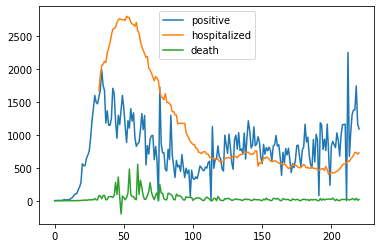

In [7]:

subset_df = political_entity.loc[:,['positive']]
arr = subset_df[:].to_numpy()
reversed_arr = arr[::-1]
reversed_arr = reversed_arr[-days_back:]
plt.plot(reversed_arr[0:], label = 'positive')

subset_df = political_entity.loc[:,['hospitalized']]
arr = subset_df[:].to_numpy()
reversed_arr = arr[::-1]
reversed_arr = reversed_arr[-days_back:]
plt.plot(reversed_arr[0:], label = 'hospitalized')

subset_df = political_entity.loc[:,['death']]
arr = subset_df[:].to_numpy()
reversed_arr = arr[::-1]
reversed_arr = reversed_arr[-days_back:]
plt.plot(reversed_arr[0:], label = 'death')

plt.legend()
plt.show()


# References

- https://www-doh.state.nj.us/doh-shad/view/sharedstatic/CrudeDeathRate.pdf
- https://www.cnn.com/resources/coronavirus-information/19067


In [8]:
# us

,date,positive,tests,hospitalized,death_total,death,positive_total,pos_rate,death_rate,death_rate_est
0,2020-10-12,43043,1003578,35056.0,206881.0,284,7770673,4.288954,2.662331,0.266233
1,2020-10-11,46776,943645,34028.0,206597.0,464,7727630,4.956949,2.673485,0.267348
2,2020-10-10,57206,1133178,34611.0,206133.0,663,7680854,5.048280,2.683725,0.268373
3,2020-10-09,57060,1092407,34839.0,205470.0,893,7623648,5.223328,2.695166,0.269517
4,2020-10-08,55352,1040059,34322.0,204577.0,986,7566588,5.322006,2.703689,0.270369
...,...,...,...,...,...,...,...,...,...,...
260,2020-01-26,0,0,NaN,NaN,0,0,NaN,NaN,NaN
261,2020-01-25,0,0,NaN,NaN,0,0,NaN,NaN,NaN
262,2020-01-24,0,0,NaN,NaN,0,0,NaN,NaN,NaN
263,2020-01-23,0,1,NaN,NaN,0,0,0.000000,NaN,NaN


In [9]:
summary.head(14)

,date,pos_us,pos_rate_us,hosp_us,pos_pa,pos_rate_pa,hosp_pa,pos_nj,pos_rate,hosp_nj
0,2020-10-12,43043,4.288954,35056.0,1088.0,8.955470,725.0,469,0.825341,662.0
1,2020-10-11,46776,4.956949,34028.0,1166.0,7.585713,706.0,751,100.000000,170.0
2,2020-10-10,57206,5.048280,34611.0,1742.0,8.133726,732.0,864,2.466246,641.0
3,2020-10-09,57060,5.223328,34839.0,1380.0,8.602419,734.0,865,2.381542,666.0
4,2020-10-08,55352,5.322006,34322.0,1376.0,7.266198,687.0,1298,2.132869,652.0
5,2020-10-07,50602,5.865103,32105.0,1309.0,7.764399,657.0,508,2.196947,601.0
6,2020-10-06,38661,4.690429,31346.0,1036.0,8.579000,633.0,629,100.000000,553.0
7,2020-10-05,38133,4.069347,30098.0,672.0,6.727400,594.0,511,2.132365,507.0
8,2020-10-04,38439,4.009149,29944.0,2251.0,7.784887,603.0,626,1.025893,480.0
9,2020-10-03,51372,5.137739,30106.0,0.0,NaN,573.0,947,100.000000,485.0
